# Main

This model will take in a valence-arousal vector and a Bouba-Kiki vector. It will then output an encoded earcon representation, which will be passed to the MusicGen Decoder to generate the final earcon.

The output of the MusicGen Decoder will then be encoded by EncodecFeatureExtractor, and the vectors will be used to calculate the loss

## Dataset

Each row in the dataset will consist of:
- An Earcon represented by an Encodec vector
- An image represented in a Valence Arousal Vector
- A Bouba-Kiki Value derived from the image
- A Pseudoword

The rows will be paired by cosine similarity between the Earcon's Encodec vector and the VA Vector from the image. The Bouba-Kiki Value and Pseudoword will be generated after the images are paired with the audio

In [ ]:
# import relevant libraries
import pandas as pd
import numpy as np
import ast
import torch
import random


random.seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
pd.set_option('display.max_columns', None)

### Earcons

In [ ]:
# load in earcons
earcons = pd.read_csv('dataset\earcon_dataset\earcon_dataset.csv')

earcons['query'] = earcons['query'].apply(ast.literal_eval)
earcons["query"] = earcons["query"].apply(lambda x: x[0])

earcons = earcons[["query", "name"]]

earcons["filepaths"] = earcons["name"].apply(lambda x: f"dataset/earcon_dataset/earcons/{x}")

earcons

In [ ]:
# prep encodec model
from encodec import EncodecModel


encodec_model = EncodecModel.encodec_model_24khz().to(device)

In [ ]:
import torchaudio


def extract_earcon_features(filepaths, encodec_model, target_sample_rate=24000, target_length=512):
    earcon_features = []

    for path in filepaths:
        # load in the audio file
        waveform, sample_rate = torchaudio.load(path)
        waveform = waveform.to(device)

        # if stereo, convert to mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True).to(device)

        # resample if necessary
        if sample_rate != target_sample_rate:
            resampler = torchaudio.transforms.Resample(sample_rate, target_sample_rate).to(device)
            waveform = resampler(waveform).to(device)

        # add batch dimension so that the shape is
        # [1, 1, num_samples] because encodec
        # expects that format
        waveform = waveform.unsqueeze(0)

        # encode the waveform
        with torch.no_grad():
            encoded_frames = encodec_model.encode(waveform)
            compressed_features = encoded_frames[0][0].to(device)  # Take the first codebook
        
        # truncate and pad
        length = compressed_features.shape[2]
        if length > target_length:
            compressed_features = compressed_features[:, :, :target_length].to(device)
        else:
            pad = torch.zeros((compressed_features.shape[0], compressed_features.shape[1], target_length - length)).to(device)
            compressed_features = torch.cat((compressed_features, pad), dim=2).to(device)

        # remove the first dimension
        compressed_features = compressed_features.squeeze(0)
        earcon_features.append(compressed_features.to("cpu"))

    return earcon_features


# Apply the function to all rows in the earcons dataframe
earcons["earcon_features"] = extract_earcon_features(earcons["filepaths"], encodec_model)
earcons

In [ ]:
earcons["earcon_features"][0].shape

In [ ]:
# find the largest value embedded in the earcon features

smallest = 1000000
largest = 0
for i in range(len(earcons["earcon_features"])):
    if largest < int(earcons["earcon_features"][i].max()):
        largest = int(earcons["earcon_features"][i].max())
    if smallest > int(earcons["earcon_features"][i].min()):
        smallest = int(earcons["earcon_features"][i].min())

print(largest)
print(smallest)

### Images

In [ ]:
# load in images
images = pd.read_csv('dataset\landscape1\csvs\image_classification.csv')

# extract top tag and similarity score
images['top_tags'] = images['top_tags'].apply(ast.literal_eval)
images["top_tags"] = images["top_tags"].apply(lambda x: x[0])
images["similarity_scores"] = images["similarity_scores"].apply(ast.literal_eval)
images["similarity_scores"] = images["similarity_scores"].apply(lambda x: x[0])

images["image_path"] = images["image_path"].str.lstrip("../")

In [ ]:

# load CLIP model
from transformers import CLIPProcessor, CLIPModel
from PIL import Image


# Function to calculate image vectors
def calculate_image_vectors(image_paths, clip_model, clip_processor):
    image_features = []
    count = 0
    for image_path in image_paths:
        count += 1
        image = clip_processor(images=Image.open(image_path), return_tensors="pt").pixel_values.to(device)
        with torch.no_grad():
            image = clip_model.get_image_features(image)
            image = image.squeeze(0)
            image_features.append(image.to("cpu"))
        if count % 1000 == 0:
            print(f"Processed {count} images")
    return image_features


# Apply the function to the images dataframe
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

images["image_features"] = calculate_image_vectors(images["image_path"].tolist(), clip_model, clip_processor)
images

In [ ]:
images["image_features"][0].shape

### Calculate Cosine Similarity

This will be used to build the dataset for our model

In [ ]:
# calculate the cosine similarity & store in a new df
from sklearn.metrics.pairwise import cosine_similarity


def compute_torch_cosine_similarity(image_vectors, earcon_vectors):
    # Convert to PyTorch tensors
    image_tensor = torch.tensor(np.stack(image_vectors))
    earcon_tensor = torch.tensor(np.mean(np.stack(earcon_vectors), axis=1)).float()
    
    # Normalize vectors
    image_tensor_norm = image_tensor / image_tensor.norm(dim=1, keepdim=True)
    earcon_tensor_norm = earcon_tensor / earcon_tensor.norm(dim=1, keepdim=True)
    
    # Compute cosine similarity
    similarity_matrix = torch.mm(image_tensor_norm, earcon_tensor_norm.t())
    
    return similarity_matrix.numpy()


def process_similarities(images, earcons):
    # Compute similarity matrix (using one of the methods above)
    similarity_matrix = compute_torch_cosine_similarity(
        images['image_features'].tolist(), 
        earcons['earcon_features'].tolist()
    )
    
    # Find the index of the most similar earcon for each image
    most_similar_indices = np.argmax(similarity_matrix, axis=1)
    
    # Extract the most similar earcon details
    result_df = pd.DataFrame({
        'split': images['split'],
        'earcon_filename': earcons.iloc[most_similar_indices]['name'].values,
        'earcon_filepath': earcons.iloc[most_similar_indices]['filepaths'].values,
        'earcon_features': earcons.iloc[most_similar_indices]['earcon_features'].values,
        'image_filename': images['filename'],
        'image_filepath': images['image_path'],
        'image_features': images['image_features'],
        'image_tag': images['top_tags'],
        'image_tag_similarity': images['similarity_scores'],
        'similarity_score': similarity_matrix[np.arange(len(most_similar_indices)), most_similar_indices]
    })
    
    return result_df

earcon_image_dataset = process_similarities(images, earcons)
earcon_image_dataset

In [ ]:
earcon_image_dataset.earcon_filename.value_counts()

### Build Pseudowords and Bouba-Kiki value

In [ ]:
import random
from joblib import Parallel, delayed
import utils.psword_gen as psword_gen
import utils.psword_utils as psword_utils


def generate_pseudoword_and_bouba_kiki(image_path, sound_dict):
    x_values, y_values = psword_utils.process_image(image_path, 50, 150)
    weighted_angles, roundness = psword_utils.calculate_weighted_angles_by_edge_length(x_values, y_values)
    
    random.seed(42)
    
    psword = psword_gen.pseudoword_generator(
        roundness,
        len(x_values),
        sound_dict=sound_dict
    )
    
    return roundness, psword, weighted_angles

# Parallelized function
def process_row(row):
    return generate_pseudoword_and_bouba_kiki(row['image_filepath'], sound_dict)


# sound dict
sound_dict = psword_gen.load_sound_mappings('utils/sound_mappings.json')

# Parallelize using joblib
results = Parallel(n_jobs=-1)(delayed(process_row)(row) for _, row in earcon_image_dataset.iterrows())

# Extract and assign results
earcon_image_dataset[['roundness', 'pseudoword', 'weighted_angles']] = pd.DataFrame(results, index=earcon_image_dataset.index)

earcon_image_dataset

### Save to pickle

In [ ]:
earcon_image_dataset.to_pickle('dataset/combined_dataset/earcon_image_dataset2.pkl')

## Training

In [1]:
# import relevant libraries
import pandas as pd
import torch
import random


random.seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
pd.set_option('display.max_columns', None)

### Load from pickle

In [2]:
import pandas as pd

earcon_image_dataset = pd.read_pickle('dataset/combined_dataset/earcon_image_dataset2.pkl')
earcon_image_dataset

,split,earcon_filename,earcon_filepath,earcon_features,image_filename,image_filepath,image_features,image_tag,image_tag_similarity,similarity_score,roundness,pseudoword,weighted_angles
0,test,BS_Bend_20.wav,dataset/earcon_dataset/earcons/BS_Bend_20.wav,"[[tensor(930.), tensor(534.), tensor(530.), te...",Coast-Test (1).jpeg,dataset/landscape1/Testing Data/Coast\Coast-Te...,"[tensor(0.5427), tensor(-0.2114), tensor(-0.54...",a natural landscape,0.098083,0.059398,0.548406,juxuluji,98.713105
1,test,Failure_01.wav,dataset/earcon_dataset/earcons/Failure_01.wav,"[[tensor(913.), tensor(945.), tensor(530.), te...",Coast-Test (100).jpeg,dataset/landscape1/Testing Data/Coast\Coast-Te...,"[tensor(0.1623), tensor(-0.0117), tensor(-0.17...",a natural landscape,0.120972,0.057352,0.515597,juxulu,92.807444
2,test,BS_Bend_17.wav,dataset/earcon_dataset/earcons/BS_Bend_17.wav,"[[tensor(319.), tensor(698.), tensor(857.), te...",Coast-Test (101).jpeg,dataset/landscape1/Testing Data/Coast\Coast-Te...,"[tensor(0.5334), tensor(-0.1099), tensor(-0.36...",a calm landscape,0.133911,0.072991,0.562980,geleje,101.336326
3,test,clock.wav,dataset/earcon_dataset/earcons/clock.wav,"[[tensor(62.), tensor(62.), tensor(62.), tenso...",Coast-Test (102).jpeg,dataset/landscape1/Testing Data/Coast\Coast-Te...,"[tensor(0.8153), tensor(-0.2710), tensor(0.351...",a bright landscape,0.113892,0.056997,0.533194,juxulu,95.974916
4,test,Failure_01.wav,dataset/earcon_dataset/earcons/Failure_01.wav,"[[tensor(913.), tensor(945.), tensor(530.), te...",Coast-Test (103).jpeg,dataset/landscape1/Testing Data/Coast\Coast-Te...,"[tensor(0.3290), tensor(-0.2365), tensor(-0.14...",a bright landscape,0.127563,0.066242,0.551611,geleje,99.289937
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,validation,Testeregitar_-_F.wav,dataset/earcon_dataset/earcons/Testeregitar_-_...,"[[tensor(834.), tensor(604.), tensor(432.), te...",Mountain-Valid (95).jpeg,dataset/landscape1/Validation Data/Mountain\Mo...,"[tensor(-0.1323), tensor(0.4341), tensor(0.136...",a intense landscape,0.072266,0.040474,0.544531,juxuluji,98.015541
11996,validation,Anvil_-_Lokomo_A_100_kg_-_Hammer_on_back_1_tim...,dataset/earcon_dataset/earcons/Anvil_-_Lokomo_...,"[[tensor(170.), tensor(748.), tensor(748.), te...",Mountain-Valid (96).jpeg,dataset/landscape1/Validation Data/Mountain\Mo...,"[tensor(-0.3210), tensor(0.1672), tensor(0.141...",a complex landscape,0.069275,0.056088,0.512671,juxuluja,92.280799
11997,validation,Short_Cut-Off_Beep.wav,dataset/earcon_dataset/earcons/Short_Cut-Off_B...,"[[tensor(103.), tensor(56.), tensor(0.), tenso...",Mountain-Valid (97).jpeg,dataset/landscape1/Validation Data/Mountain\Mo...,"[tensor(0.3450), tensor(0.3041), tensor(0.0990...",a narrow landscape,0.117004,0.043641,0.532324,juxuluji,95.818241
11998,validation,BS_Bend_17.wav,dataset/earcon_dataset/earcons/BS_Bend_17.wav,"[[tensor(319.), tensor(698.), tensor(857.), te...",Mountain-Valid (98).jpeg,dataset/landscape1/Validation Data/Mountain\Mo...,"[tensor(0.1858), tensor(-0.0550), tensor(-0.14...",a sharp landscape,0.099854,0.048247,0.554051,gelejegi,99.729109


### Build Dataloaders

In [3]:
# Split the dataset based on the "split" column
train_df = earcon_image_dataset[earcon_image_dataset['split'] == 'train']
train_df = train_df.drop(columns='split')
val_df = earcon_image_dataset[earcon_image_dataset['split'] == 'validation']
val_df = val_df.drop(columns='split')
test_df = earcon_image_dataset[earcon_image_dataset['split'] == 'test']
test_df = test_df.drop(columns='split')

In [4]:
train_df = train_df.sample(frac=0.01, random_state=42)
val_df = val_df.sample(frac=0.05, random_state=42)
test_df = test_df.sample(frac=1, random_state=42)
len(train_df), len(val_df), len(test_df)

(100, 75, 500)

In [5]:
# Create dataloaders
from utils.musicgen_utils import create_earcon_dataloaders
train_loader, val_loader, test_loader = create_earcon_dataloaders(train_df, val_df, test_df, batch_size=5, num_workers=0)

### Model

The model pipeline is as follows:
- The Earcon Encodec Vector is the target
- The VA Vector and Bouba-Kiki Value will be inputs to the model
- The model will output a set of vectors which will be fed to the MusicGen Decoder along with the Pseudoword
- The output of MusicGen Decoder will be encoded by Encodec
- The output of Encodec will be considered the final output, and loss will be calculated based on the difference between this output and the target Encodec vector from the Earcon

In [6]:
# init model
from utils.musicgen_model import *
from utils.musicgen_utils import *


model_options = {
    "freeze_musicgen_text_encoder": False,
    "freeze_musicgen_decoder": False,
    "freeze_encodec": True,
    "num_projection_layers": 2,
    "fusion_hidden_dims": [256]
}

model = MultimodalEarconGenerator(
    freeze_musicgen_text_encoder=model_options["freeze_musicgen_text_encoder"],
    freeze_musicgen_decoder=model_options["freeze_musicgen_decoder"],
    freeze_encodec=model_options["freeze_encodec"],
    num_projection_layers=model_options["num_projection_layers"],
    fusion_hidden_dims=model_options["fusion_hidden_dims"]
)

c:\Users\qkm20\anaconda3\envs\fyp\Lib\site-packages\torch\nn\utils\weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [7]:
print(model)

MultimodalEarconGenerator(
  (encodec): EncodecModel(
    (encoder): SEANetEncoder(
      (model): Sequential(
        (0): SConv1d(
          (conv): NormConv1d(
            (conv): Conv1d(1, 32, kernel_size=(7,), stride=(1,))
            (norm): Identity()
          )
        )
        (1): SEANetResnetBlock(
          (block): Sequential(
            (0): ELU(alpha=1.0)
            (1): SConv1d(
              (conv): NormConv1d(
                (conv): Conv1d(32, 16, kernel_size=(3,), stride=(1,))
                (norm): Identity()
              )
            )
            (2): ELU(alpha=1.0)
            (3): SConv1d(
              (conv): NormConv1d(
                (conv): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
                (norm): Identity()
              )
            )
          )
          (shortcut): SConv1d(
            (conv): NormConv1d(
              (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
              (norm): Identity()
            )
          )


In [8]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

musicgen.decoder.embed_tokens.0.weight torch.Size([2049, 1024])
musicgen.decoder.layers.0.self_attn.k_proj.weight torch.Size([1024, 1024])
musicgen.decoder.layers.0.self_attn.v_proj.weight torch.Size([1024, 1024])
musicgen.decoder.layers.0.self_attn.q_proj.weight torch.Size([1024, 1024])
musicgen.decoder.layers.0.self_attn.out_proj.weight torch.Size([1024, 1024])
musicgen.decoder.layers.0.self_attn_layer_norm.weight torch.Size([1024])
musicgen.decoder.layers.0.self_attn_layer_norm.bias torch.Size([1024])
musicgen.decoder.layers.0.encoder_attn.k_proj.weight torch.Size([1024, 1024])
musicgen.decoder.layers.0.encoder_attn.v_proj.weight torch.Size([1024, 1024])
musicgen.decoder.layers.0.encoder_attn.q_proj.weight torch.Size([1024, 1024])
musicgen.decoder.layers.0.encoder_attn.out_proj.weight torch.Size([1024, 1024])
musicgen.decoder.layers.0.encoder_attn_layer_norm.weight torch.Size([1024])
musicgen.decoder.layers.0.encoder_attn_layer_norm.bias torch.Size([1024])
musicgen.decoder.layers.0.

### Training the model

In [9]:
# optimizer
import torch.optim as optim


# hyper parameters
patience = 5
epochs = 50

trainable_params = [
    param for param in model.parameters() if param.requires_grad
]

optimizer = optim.AdamW(
    trainable_params,
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=1e-5
)

# optimizer = optim.Adam(
#     trainable_params,
#     lr=0.001,
#     betas=(0.9, 0.999),
#     eps=1e-08,
#     weight_decay=1e-5
# )

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',  # minimize validation loss
#     factor=0.5,  # reduce learning rate by half
#     patience=2,  # wait for 2 epochs before reducing lr
#     min_lr=1e-6  # minimum learning rate
# )

# scheduler = optim.lr_scheduler.StepLR(
#     optimizer,
#     step_size=5,  # reduce learning rate every 5 epochs
#     gamma=0.5     # multiply lr by 0.5 each step
# )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=epochs,  # total number of epochs
    eta_min=1e-6   # minimum learning rate
)

In [10]:
# train model
train_multimodal_earcon_model(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    optimizer=optimizer,
    epochs=epochs,
    patience=patience,
)

Epoch 1/50 - Training:   0%|          | 0/20 [00:00<?, ?it/s]c:\Users\qkm20\anaconda3\envs\fyp\Lib\site-packages\transformers\models\musicgen\modeling_musicgen.py:539: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch 1/50, Training Loss: 1627.8531, Validation Loss: 1623.5498, Learning Rate: 0.001


Epoch 2/50, Training Loss: 1652.9379, Validation Loss: 1625.8144, Learning Rate: 0.001
No improvement for 1/5 epochs.


Epoch 3/50, Training Loss: 1619.3323, Validation Loss: 1645.3043, Learning Rate: 0.001
No improvement for 2/5 epochs.


Epoch 4/50, Training Loss: 1630.6898, Validation Loss: 1615.6881, Learning Rate: 0.001


Epoch 5/50, Training Loss: 1602.1616, Validation Loss: 1652.6714, Learning Rate: 0.001
No improvement for 1/5 epochs.


Epoch 6/50, Training Loss: 1614.1641, Validation Loss: 1623.6100, Learning Rate: 0.001
No improvement for 2/5 epochs.


Epoch 7/50, Training Loss: 1599.1917, Validation Loss: 1620.3163, Learning Rate: 0.001
No improvement for 3/5 epochs.


Epoch 8/50, Training Loss: 1626.5042, Validation Loss: 1617.4501, Learning Rate: 0.001
No improvement for 4/5 epochs.


Epoch 9/50, Training Loss: 1611.5755, Validation Loss: 1616.1957, Learning Rate: 0.001
No improvement for 5/5 epochs.
Early stopping triggered.


In [11]:
version = "7"

In [12]:
save_multimodal_model(model, filename=f"MusicGenModel_0{version}")

Model saved to outputs\MusicGenModel_07.pt


## Testing

In [13]:
# import relevant libraries
import pandas as pd
import torch
import random


random.seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
pd.set_option('display.max_columns', None)

In [14]:
# Loading model
from utils.musicgen_model import *

model = MultimodalEarconGenerator(
    freeze_musicgen_text_encoder=model_options["freeze_musicgen_text_encoder"],
    freeze_musicgen_decoder=model_options["freeze_musicgen_decoder"],
    freeze_encodec=model_options["freeze_encodec"],
    num_projection_layers=model_options["num_projection_layers"],
    fusion_hidden_dims=model_options["fusion_hidden_dims"])
model = load_multimodal_model(model, model_path=f"outputs/MusicGenModel_0{version}.pt")

f:\OneDrive - Nanyang Technological University\FYP\FYP\utils\musicgen_model.py:368: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_checkpoint = torch.load(model_path, m

Model loaded from outputs/MusicGenModel_07.pt


In [15]:
# choose 10 unique random image/earcon pairs for testing
elements = random.sample(range(0, len(test_df)), 10)
elements.sort()
elements

[12, 52, 57, 71, 114, 125, 140, 327, 377, 379]

In [18]:
# generate the audio for the selected pairs
from transformers import T5Tokenizer


audio_list = []
tokenizer = T5Tokenizer.from_pretrained("facebook/musicgen-small")

for i in range(len(elements)):
    audio_list.append(
        generate_earcon(
            model,
            test_df["image_features"].iloc[elements[i]],
            test_df["roundness"].iloc[elements[i]],
        )
    )

In [17]:
from IPython.display import Audio, display, Image


def display_image(image_path):
    display(Image(filename=image_path))


def play_audio(filepath):
    display(Audio(filepath))


def play_generated_audio(audio, sampling_rate=24000):
    display(Audio(audio[0].cpu().numpy(), rate=sampling_rate))

Image 1:


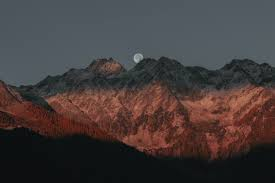

Original Paired Earcon 1:


Generated Earcon 1:


Image 2:


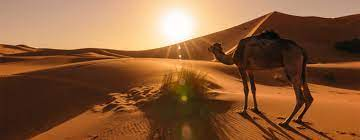

Original Paired Earcon 2:


Generated Earcon 2:


Image 3:


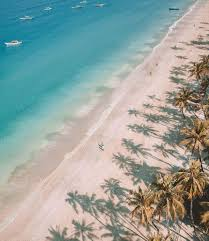

Original Paired Earcon 3:


Generated Earcon 3:


Image 4:


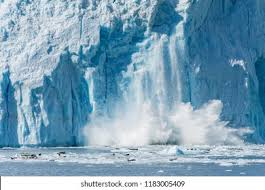

Original Paired Earcon 4:


Generated Earcon 4:


Image 5:


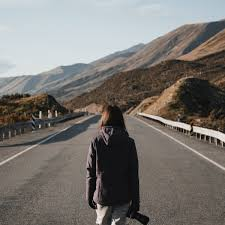

Original Paired Earcon 5:


Generated Earcon 5:


Image 6:


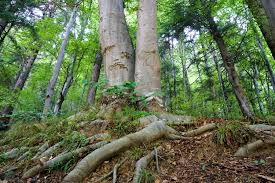

Original Paired Earcon 6:


Generated Earcon 6:


Image 7:


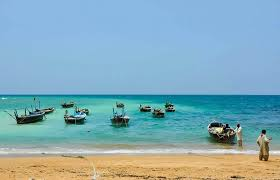

Original Paired Earcon 7:


Generated Earcon 7:


Image 8:


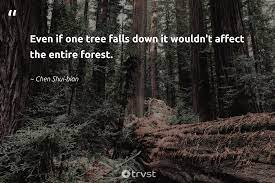

Original Paired Earcon 8:


Generated Earcon 8:


Image 9:


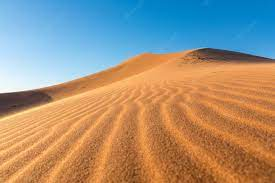

Original Paired Earcon 9:


Generated Earcon 9:


Image 10:


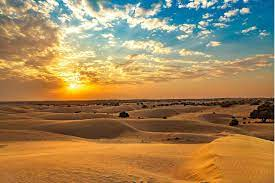

Original Paired Earcon 10:


Generated Earcon 10:


In [19]:
# display the images and play the audio for every pair
for i in range(len(elements)):
    # display image
    print(f"Image {i+1}:")
    display_image(test_df["image_filepath"].iloc[elements[i]])
    # play paired earcon
    print(f"Original Paired Earcon {i+1}:")
    play_audio(test_df["earcon_filepath"].iloc[elements[i]])
    # play generated earcon
    print(f"Generated Earcon {i+1}:")
    play_generated_audio(audio_list[i])